# シュレーディンガーの猫状態を準備し、シミュレーターで回路を実行する

In [ ]:
# # Use Braket SDK Cost Tracking to estimate the cost to run this example
# from braket.tracking import Tracker
# t = Tracker().start()

<div class="alert alert-block alert-info">
このノートブックは、Amazon Braket のスタート時にクローンされるノートブック
Braket examples/getting_started/1_Running_quantum_circuits_on_simulators.ipynb
に日本語訳と編集を加えたものです。
</div>

この チュートリアルでは、 [GHZ状態](https://en.wikipedia.org/wiki/Greenberger%E2%80%93Horne%E2%80%93Zeilinger_state) と呼ばれる、複数の量子ビットがエンタングルした非常に量子性の強い状態を作ります。（3人の物理学者Greenberger、Horne、Zeilingerにちなんで名付けられました）。GHZ状態は非常に非古典的（量子的）であるため、デコヒーレンス（外部からの擾乱）に非常に敏感です。 したがって、今日のハードウェアのパフォーマンスベンチマークとしてよく使用されます。 さらに、多くの量子情報プロトコルでは、量子エラー訂正、量子通信、量子計測のリソースとして使用されています。

この量子状態は、ローカルシミュレーターまたはクラウドベースのマネージドシミュレーター SV1 で回路を実行できます。 古典シミュレータで構成した回路は、デバイスオブジェクトを再定義するだけで、回路定義を変更することなく、量子マシンでスムーズに実行できます。

In [1]:
# general imports
import matplotlib.pyplot as plt
# magic word for producing visualizations in notebook
%matplotlib inline
import time
import numpy as np

# AWS imports: Import Braket SDK modules
from braket.circuits import Circuit, Observable
from braket.devices import LocalSimulator
from braket.aws import AwsDevice
from braket.tracking import Tracker

### 問題：GHZ 状態を準備する

目標：$N$ 量子ビット GHZ 状態を準備します（多くの量子情報処理やセンシングプロトコルで使われる基本的な量子状態です）：

$$\left|0,0, ...\right> \rightarrow \left|\mathrm{GHZ}\right> = \frac{1}{\sqrt{2}}\left(\left|0,0, ...\right> + \left|1,1, ...\right>\right).$$

GHZ状態は、いわゆる「シュレーディンガーの猫状態」としてよく知られています。 量子ビットの状態が全て0という状態と、すべての状態1という状態の量子的な重ね合わせ状態で、最も絡み合った量子状態のことを指します。

この状態を準備するために、最初の量子ビットに作用する単一キュービットのアダマールゲート（Hと表記）とそれに続く一連の2キュービットのCNOTゲートを使用して、次の回路を構築して実行します。

<div>
<img src="circuit.png" width="500"/>
</div>

### 回路のセットアップ
量子回路をセットアップします。


In [2]:
# function to build GHZ state
def ghz_circuit(n_qubits):
    """
    function to return GHZ circuit ansatz
    input: number of qubits
    """

    # instantiate circuit object
    circuit = Circuit()
    
    # add Hadamard gate on first qubit
    circuit.h(0)

    # apply series of CNOT gates
    for ii in range(0, n_qubits-1):
        circuit.cnot(control=ii, target=ii+1)

    return circuit

In [3]:
# define circuit
n_qubits = 10
ghz = ghz_circuit(n_qubits)

In [4]:
# print circuit
print(ghz)

T  : |0|1|2|3|4|5|6|7|8|9|
                          
q0 : -H-C-----------------
        |                 
q1 : ---X-C---------------
          |               
q2 : -----X-C-------------
            |             
q3 : -------X-C-----------
              |           
q4 : ---------X-C---------
                |         
q5 : -----------X-C-------
                  |       
q6 : -------------X-C-----
                    |     
q7 : ---------------X-C---
                      |   
q8 : -----------------X-C-
                        | 
q9 : -------------------X-

T  : |0|1|2|3|4|5|6|7|8|9|


### Local Simulator

まず、ローカルシミュレータを使用して、回路をローカルで実行します。

In [5]:
# set up device: Local Simulator
device = LocalSimulator()

In [6]:
# run circuit
result = device.run(ghz, shots=1000).result()
# get measurement shots
counts = result.measurement_counts
# print counts
print(counts)

Counter({'1111111111': 504, '0000000000': 496})


Text(0, 0.5, 'counts')

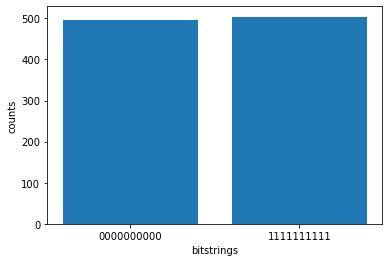

In [7]:
# plot using Counter
plt.bar(counts.keys(), counts.values())
plt.xlabel('bitstrings')
plt.ylabel('counts')

測定ショットにしかアクセスできない量子ハードウェアとは対照的に、古典的なシミュレータでは、結果タイプを割り当てることにより、対応する観測量に対する完全な状態ベクトル、振幅、および期待値にアクセスできます。 そのためには、量子タスクを送信する前に、測定したい結果タイプを回路に追加する必要があります。 これは、デバッグに非常に役立ちます。

3量子ビットGHZ状態の場合、状態ベクトル、$Z\otimes Z\otimes Z$の期待値、$|111\rangle$状態の振幅を出力し、次のような出力が期待されます。
$\left|\mathrm{GHZ}\right> = \frac{1}{\sqrt{2}}\left(\left|0,0,0\right> + \left|1,1,1\right>\right) = \left[\frac{1}{\sqrt{2}},0,0,0,0,0,0,\frac{1}{\sqrt{2}}\right],$

$\left<ZZZ\right>=0$, $\left<111|\mathrm{GHZ}\right>=\frac{1}{\sqrt{2}}$.

In [8]:
# define circuit
n_qubits = 3
ghz = ghz_circuit(n_qubits)      

# add the state_vector ResultType
ghz.state_vector()
# add the Z \otimes Z \otimes Z expectation value
ghz.expectation(Observable.Z() @ Observable.Z() @ Observable.Z(), target=[0,1,2])
# add the amplitude for |111>
ghz.amplitude(state=["111"])
# print circuit including requested result types
print(ghz)

T  : |0|1|2|   Result Types   |
                               
q0 : -H-C---Expectation(Z@Z@Z)-
        |   |                  
q1 : ---X-C-Expectation(Z@Z@Z)-
          | |                  
q2 : -----X-Expectation(Z@Z@Z)-

T  : |0|1|2|   Result Types   |

Additional result types: StateVector, Amplitude(111)


In [9]:
# run the circuit and output the results
task = device.run(ghz, shots=0)
result = task.result()

# print results
print("Final EXACT state vector:\n", result.values[0])
print("Expectation value <ZZZ>:", np.round(result.values[1], 5))
print("Amplitude <111|Final state>:", result.values[2])

Final EXACT state vector:
 [0.70710678+0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.70710678+0.j]
Expectation value <ZZZ>: 0.0
Amplitude <111|Final state>: {'111': (0.7071067811865475+0j)}


GHZ状態を構成する、完全に相関関係のある3量子ビットの期待される結果を返していることがわかります。

状態ベクトルと振幅は、古典的なシミュレータにおいてショット= 0の場合にのみ実行できることに注意してください。 シミュレータにおけるショット=0の場合、確率、期待値、および分散は、波動関数から導出された正確な値を意味します。 ショットが0より大きい場合、測定サンプルから取得した期待値に対応し、完全な状態ベクトルにアクセスすることはできません。 QPUデバイスでは、確率、サンプル、期待値、分散もサポートされていることに注意してください。

### マネージドな量子計算シミュレータ SV1

上記の Local Simulator とは対照的に、クラウドベースのシミュレータ SV1 で量子回路を実行することができます。 このアプローチでは、AWS 内部の別のリソースにアクセス レイテンシのオーバーヘッドがいくらか追加されますが、最適化されたクラウドハードウェアインフラストラクチャを活用することで、大規模な回線に役立ちます。 さらに、すべての結果は S3 に確実に保存されます。 ここでは、 ```run（）``` を使用したAPI呼び出しの一部として、この回路の実行に関連するメタデータと結果が保存される S3 の場所を指定する必要があります。

In [10]:
# set up device
device = AwsDevice("arn:aws:braket:::device/quantum-simulator/amazon/sv1")

In [11]:
# define larger GHZ circuit
n_qubits = 15
ghz = ghz_circuit(n_qubits)

Counter({'000000000000000': 528, '111111111111111': 472})
Counts for all-zero bitstring: 528
Counts for all-one bitstring: 472
CPU times: user 146 ms, sys: 14.6 ms, total: 160 ms
Wall time: 3.67 s


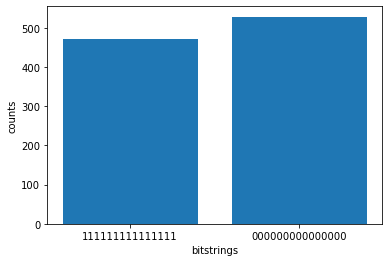

In [12]:
%%time
# run GHZ circuit on cloud simulator
result = device.run(ghz, shots=1000).result()
counts = result.measurement_counts
print(counts)

# plot using Counter
plt.bar(counts.keys(), counts.values());
plt.xlabel('bitstrings');
plt.ylabel('counts');  

# print counts of all-zero-string
print('Counts for all-zero bitstring:', counts['0'*n_qubits])
# print counts of all-one-string
print('Counts for all-one bitstring:', counts['1'*n_qubits])

__NOTE__: QPUやSV1を扱う場合、タスクごとにユニークなIDが割り振られます。AWS コンソールでタスクについて確認してみましょう。

In [13]:
# print unique TASK ID (task = execution of individual circuit)
task_id = result.task_metadata.id
# recover other metadata information such as number of qubits
n = result.task_metadata.deviceParameters.paradigmParameters.qubitCount
print('Task ID:', task_id)
print('Number of qubits:', n)

Task ID: arn:aws:braket:us-west-2:137983788483:quantum-task/4ca813f3-8a30-4865-a082-5eaca38a5800
Number of qubits: 15


### マネージドな量子計算シミュレーターSV1でタスクを並列送信する

マネージドシミュレーターを使用すると、タスクを並行して送信できます。 これらのタスクはキューに入り、タスクが実行された後に結果が返されます。 以下のセルは、並列タスクをマネージドシミュレーターに送信する例を示しています。

In [14]:
with Tracker() as tracker:
    tasks = {}
    results = {}
    # submit tasks in parallel 
    for n_qubits in range(25,31):
        ghz = ghz_circuit(n_qubits)
        tasks[n_qubits] = device.run(ghz, shots=1000)
        print('{}-qubit task {}'.format(n_qubits,tasks[n_qubits].state()))

    print('\n')

    for n_qubits in range(25,31):
        # check the status of the task and wait until the task is complete
        status = tasks[n_qubits].state()
        while status != 'COMPLETED':
            status = tasks[n_qubits].state()

        results[n_qubits] = tasks[n_qubits].result()
        # get the running time of the task
        runtime = results[n_qubits].additional_metadata.simulatorMetadata.executionDuration
        # get the 'shots' parameter from metadata
        num_shots = results[n_qubits].task_metadata.shots
        # get the measurement counts
        counts = results[n_qubits].measurement_counts

        print('{}-qubit task {}.'.format(n_qubits,status))
        print('This task ran {} shots and the total runtime was {} ms'.format(num_shots,runtime))
        print("Measurement results: {}\n".format(counts))
        
print('${}'.format(tracker.simulator_tasks_cost()))

25-qubit task CREATED
26-qubit task CREATED
27-qubit task CREATED
28-qubit task CREATED
29-qubit task CREATED
30-qubit task CREATED


25-qubit task COMPLETED.
This task ran 1000 shots and the total runtime was 593 ms
Measurement results: Counter({'0000000000000000000000000': 518, '1111111111111111111111111': 482})

26-qubit task COMPLETED.
This task ran 1000 shots and the total runtime was 1200 ms
Measurement results: Counter({'00000000000000000000000000': 529, '11111111111111111111111111': 471})

27-qubit task COMPLETED.
This task ran 1000 shots and the total runtime was 2397 ms
Measurement results: Counter({'111111111111111111111111111': 520, '000000000000000000000000000': 480})

28-qubit task COMPLETED.
This task ran 1000 shots and the total runtime was 4858 ms
Measurement results: Counter({'1111111111111111111111111111': 530, '0000000000000000000000000000': 470})

29-qubit task COMPLETED.
This task ran 1000 shots and the total runtime was 9738 ms
Measurement results: Counter({'0000

### シミュレータによる量子ビット数に対する計算時間の指数発散

量子ビットの数 `n-qubit task` に対して 計算実行にかかった時間 `total runtime` を見ると、量子ビット数が増えると実行時間が指数的に大きくなってきていることがわかります。GHZ状態のように量子的な相関が強い計算を古典シミュレータで実行すると、量子ビットの数に対して計算時間が指数発散してしまうため、大きなサイズの量子計算をシミュレータでは扱うのが難しくなってきます。
 量子コンピュータは、量子ビットが増えた際に計算時間の増加の指数発散を抑えるアルゴリズムをうまく活用することで、従来の計算機を上回る性能を出すことを期待されています。

### [Appendix] QPUにおける量子ビットの増加に対する計算時間の変化
同じ計算を量子デバイスで実行すると、実行時間はどう変わるでしょうか？
量子ビットの数に対して計算時間は指数的に伸びているでしょうか？末尾の実行のサンプル結果を確認してみてください。

※ 以下の実験を１回実行するのに、6タスク x (1タスク:0.3ドル + 1000ショット:0.35ドル) = 3.9ドル　のコストがかかりますのでご注意ください（実行時はセルをコメントアウトしてください）

In [15]:
# set up device
device = AwsDevice("arn:aws:braket:::device/qpu/rigetti/Aspen-11")

次のセルは、上記コードを実行し、Rigettiを使ったGHZ stateの実験結果の一例です。
この結果を見ると、量子ビット数の増加に対して、計算時間は指数増加していないことがわかります。
実際の実行時間を見ると、量子ビットの持つ可能性を実感いただけたかと思います。


In [16]:
# with Tracker() as tracker:
#     tasks = {}
#     results = {}
#     # submit tasks in parallel 
#     for n_qubits in range(25,39):
#         ghz = ghz_circuit(n_qubits)
#         tasks[n_qubits] = device.run(ghz, shots=1000)
#         print('{}-qubit task {}'.format(n_qubits,tasks[n_qubits].state()))

#     print('\n')

#     for n_qubits in range(25,39):

#         # check the status of the task and wait until the task is complete
#         status = tasks[n_qubits].state()
#         while status != 'COMPLETED':
#             status = tasks[n_qubits].state()

#         results[n_qubits] = tasks[n_qubits].result()
#         # get the running time of the task
#         runtime = results[n_qubits].additional_metadata.rigettiMetadata.nativeQuilMetadata.qpuRuntimeEstimation
#         # get the 'shots' parameter from metadata
#         num_shots = results[n_qubits].task_metadata.shots
#         # get the measurement counts
#         counts = results[n_qubits].measurement_counts

#         print('{}-qubit task {}.'.format(n_qubits,status))
#         print('This task ran {} shots and the total runtime was {} ms'.format(num_shots,runtime))
#     #     print("Measurement results: {}\n".format(counts))
    
# print('${}'.format(tracker.qpu_tasks_cost()))

25-qubit task CREATED
26-qubit task CREATED
27-qubit task CREATED
28-qubit task CREATED
29-qubit task CREATED
30-qubit task CREATED
31-qubit task CREATED
32-qubit task CREATED
33-qubit task CREATED
34-qubit task CREATED
35-qubit task CREATED
36-qubit task CREATED
37-qubit task CREATED
38-qubit task CREATED


25-qubit task COMPLETED.
This task ran 1000 shots and the total runtime was 1116.5146484375 ms
26-qubit task COMPLETED.
This task ran 1000 shots and the total runtime was 981.7035522460938 ms
27-qubit task COMPLETED.
This task ran 1000 shots and the total runtime was 1057.2181396484375 ms
28-qubit task COMPLETED.
This task ran 1000 shots and the total runtime was 1067.06494140625 ms
29-qubit task COMPLETED.
This task ran 1000 shots and the total runtime was 1068.837890625 ms
30-qubit task COMPLETED.
This task ran 1000 shots and the total runtime was 1126.28955078125 ms
31-qubit task COMPLETED.
This task ran 1000 shots and the total runtime was 1229.788818359375 ms
32-qubit task COM

In [ ]:
# print("Task Summary")
# print(t.quantum_tasks_statistics())
# print('Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).')
# print(f"Estimated cost to run this example: {t.qpu_tasks_cost() + t.simulator_tasks_cost():.3f} USD")